* Preliminary explore of the data from https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data
* images are not geotiffs so use skimage - rasterio/gdla is not available on kaggle
* 450 1km x 1km satellite images in both 3-band and 16-band formats
* In this dataset that we provide, we create a set of geo-coordinates that are **in the range of x = [0,1] and y = [-1,0]**. These coordinates are transformed such that **we obscure the location of where the satellite images are taken from**. The images are from the same region on Earth.

Imagery details
* Sensor : WorldView 3
* Wavebands :
* Panchromatic: 450-800 nm
* 8 Multispectral: (red, red edge, coastal, blue, green, yellow, near-IR1 and near-IR2) 400 nm - 1040 nm
* 8 SWIR: 1195 nm - 2365 nm
* Sensor Resolution (GSD) at Nadir :
* Panchromatic: 0.31m 
* Multispectral: 1.24 m
* SWIR: Delivered at 7.5m

Dynamic Range
* Panchromatic and multispectral : 11-bits per pixel
* SWIR : 14-bits per pixel

In [1]:
#!pip install geojsonio

In [48]:
import os
import glob
import geoplot
import geopandas as gpd
import numpy as np
import pandas as pd
from skimage import io
from skimage.color import rgb2gray
import tifffile
from matplotlib import pyplot as plt
%matplotlib inline

fig_width, fig_height = 10, 10

In [3]:
data_dir = '/Users/robincole/Documents/kaggle/dstl/'

In [4]:
glob.glob(data_dir + '*')

['/Users/robincole/Documents/kaggle/dstl/grid_sizes.csv',
 '/Users/robincole/Documents/kaggle/dstl/train_wkt_v4.csv',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3',
 '/Users/robincole/Documents/kaggle/dstl/sample_submission.csv',
 '/Users/robincole/Documents/kaggle/dstl/three_band']

## Images in RGB
RGB in `three_band`

In [5]:
three_band = glob.glob(data_dir + 'three_band/*', recursive=True)
print(len(three_band))
three_band[:3]

450


['/Users/robincole/Documents/kaggle/dstl/three_band/6180_4_3.tif',
 '/Users/robincole/Documents/kaggle/dstl/three_band/6130_0_4.tif',
 '/Users/robincole/Documents/kaggle/dstl/three_band/6120_0_4.tif']

There are 450 three band images, lets show one - we take code from https://www.kaggle.com/chatcat/load-a-3-band-tif-image-and-overlay-dirt-tracks

In [6]:
image_file = three_band[0]

In [34]:
tile = '6120_2_2'
image_file=f'/Users/robincole/Documents/kaggle/dstl/three_band/{tile}.tif'

In [45]:
tif_data = tifffile.imread(image_file).transpose([1,2,0]) # Note that RGB are not in the usual order

In [46]:
def scale_coords(tif_data, grid_name, point):
    """Scale the coordinates of a polygon into the image coordinates for a grid cell"""
    w,h,_ = tif_data.shape
    Xmax, Ymin = grid_sizes.ix[grid_name][['Xmax', 'Ymin']]
    x,y = point[:,0], point[:,1]

    wp = float(w**2)/(w+1)
    xp = x/Xmax*wp

    hp = float(h**2)/(h+1)
    yp = y/Ymin*hp

    return np.concatenate([xp[:,None],yp[:,None]], axis=1)

def scale_percentile(matrix):
    """Fixes the pixel value range to 2%-98% original distribution of values"""
    orig_shape = matrix.shape
    matrix = np.reshape(matrix, [matrix.shape[0]*matrix.shape[1], 3]).astype(float)
    
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    
    matrix = (matrix - mins[None,:])/maxs[None,:]
    matrix = np.reshape(matrix, orig_shape)
    matrix = matrix.clip(0,1)
    return matrix

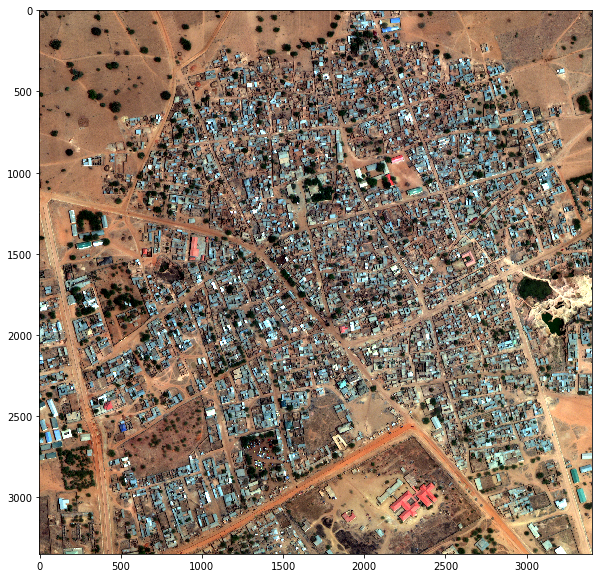

In [51]:
fixed_im = scale_percentile(tif_data)
f, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
ax.imshow(fixed_im);

## 16 Band images
The full dataset is in `sixteen_band/` and I expect these will be much more useful than just RGB

The 16 bands are distributed in the images with `file name = {ImageId}_{A/M/P}.tif`

In [8]:
sixteen_band = glob.glob(data_dir + 'sixteen_band/*', recursive=True)
print(len(sixteen_band))
sixteen_band[:6]

1350


['/Users/robincole/Documents/kaggle/dstl/sixteen_band/6080_0_3_P.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6020_4_4_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6020_0_0_A.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6120_0_3_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6010_3_3_M.tif',
 '/Users/robincole/Documents/kaggle/dstl/sixteen_band/6180_4_4_P.tif']

We have images with `P, M, A` suffixes corresponding to A band (8 channels) + M band (8 channels) + P band (1 channel)

Lets plot a PAN image

In [9]:
def get_image_id(file_path):
    """
    Return the image_id from an image file_path
    """
    return file_path.split('.')[0].split('/')[-1][:-2]

In [10]:
image_file = sixteen_band[0]
image_file

'/Users/robincole/Documents/kaggle/dstl/sixteen_band/6080_0_3_P.tif'

image_id : 6080_0_3


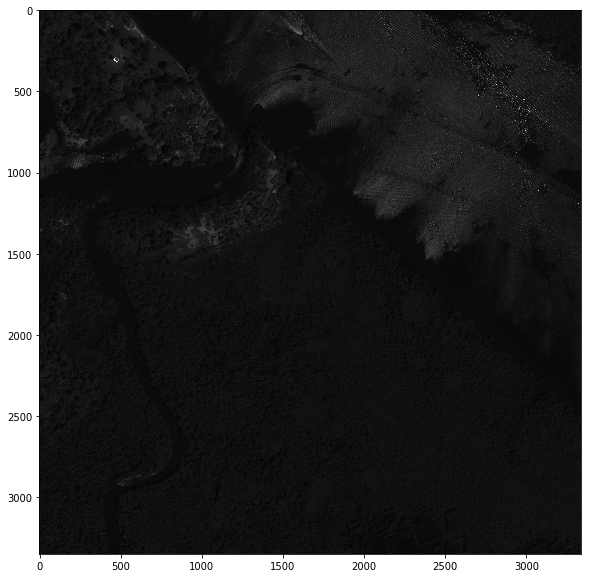

In [11]:
im = io.imread(image_file)
print(f"image_id : {get_image_id(image_file)}")

im = io.imread(image_file)
f, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
ax.imshow(rgb2gray(im), cmap=plt.cm.gray);

## Explore tabular data

### Grid sizes
First `grid_sizes` - the X,Y coordinate extents of the images
* ImageId - ID of the image
* Xmax - maximum X coordinate for the image
* Ymin - minimum Y coordinate for the image

In [12]:
grid_sizes = pd.read_csv(data_dir + 'grid_sizes.csv')

In [13]:
grid_sizes.shape

(450, 3)

In [14]:
grid_sizes.head()

,Unnamed: 0,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904


In [15]:
grid_sizes['Xmax'].max()

0.0091881

### Training labels
`train_wkt.csv` - the [WKT format](https://en.wikipedia.org/wiki/Well-known_text) of all the training labels
* ImageId - ID of the image
* ClassType - type of objects (1-10)
* MultipolygonWKT - the labeled area, which is multipolygon geometry represented in WKT format 

```
1 Buildings - large building, residential, non-residential, fuel storage facility, fortified building

2 Misc. Manmade structures 

3 Road 

4 Track - poor/dirt/cart track, footpath/trail

5 Trees - woodland, hedgerows, groups of trees, standalone trees

6 Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops

7 Waterway 

8 Standing water

9 Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle

10 Vehicle Small - small vehicle (car, van), motorbike
```

In [16]:
train_wkt = pd.read_csv(data_dir + 'train_wkt_v4.csv')

In [17]:
train_wkt.shape

(250, 3)

In [18]:
train_wkt.head(3)

,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY


In [19]:
print(len(train_wkt['ImageId'].unique()))
train_wkt['ImageId'].unique()

25


array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'],
      dtype=object)

Hmm there are only 25 training images..

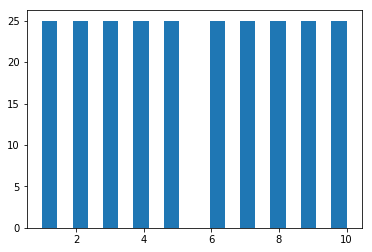

In [20]:
plt.hist(train_wkt['ClassType'], bins=20);

Appears we have uniform distribution of classes

## GeoJSON
As an alternative to wtk we have the same data in GeoJSON. We can view geojson files at http://geojson.io/ but note that these files are not geolocated.

Note that competition submission will be in the WKT format. 

In [21]:
print(len(glob.glob(data_dir + 'train_geojson_v3/*')))
train_geojson = glob.glob(data_dir + 'train_geojson_v3/*/*', recursive=True)
print(len(train_geojson))
train_geojson[:3]

25
299


['/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/001_MM_L5_MISC_SMALL_STRUCTURE.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/007_AGR_L7_FARM_ANIMALS_IN_FIELD.geojson',
 '/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/006_VEG_L2_SCRUBLAND.geojson']

There are 25 directories of geojson and approximately 12 files per directory. Lets use geopandas to load a single file

In [22]:
geo_file = train_geojson[0]
geo_file

'/Users/robincole/Documents/kaggle/dstl/train_geojson_v3/6110_4_0/001_MM_L5_MISC_SMALL_STRUCTURE.geojson'

In [24]:
geo_df = gpd.read_file(geo_file)
print(geo_df.shape)
geo_df.head()

(512, 6)


,ID,ACAD_LAYER,TILE_NAME,SUPERCLASS,LABEL,geometry
0,9a96a383-3454-406a-9eab-e9f9d5b9c711,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,"POLYGON ((0.007833 -0.000674, 0.007826 -0.0006..."
1,cf3cf024-ca06-4f64-9825-b8d7c5cd458f,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,"POLYGON ((0.000415 -0.001338, 0.00043 -0.00135..."
2,6c2fb56b-810e-4e73-a3f7-feb9ebb7dcd3,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,"POLYGON ((0.008026999999999999 -0.00187, 0.008..."
3,4a6bc1ee-ae72-44c4-858a-6fba5f1b1185,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,POLYGON ((0.00832047826086956 -0.0010141739130...
4,23360ffe-8e00-490b-953a-5edab56bc0ef,001_MM_L5_MISC_SMALL_STRUCTURE,6110_4_0,MAN-MADE,MISC_SMALL_MANMADE_STRUCTURE,"POLYGON ((0.008721 -0.001011, 0.00885 -0.00099..."


In [25]:
geo_df['LABEL'].unique()

array(['MISC_SMALL_MANMADE_STRUCTURE'], dtype=object)

In [26]:
geo_df.iloc[0]

ID                         9a96a383-3454-406a-9eab-e9f9d5b9c711
ACAD_LAYER                       001_MM_L5_MISC_SMALL_STRUCTURE
TILE_NAME                                              6110_4_0
SUPERCLASS                                             MAN-MADE
LABEL                              MISC_SMALL_MANMADE_STRUCTURE
geometry      POLYGON ((0.007833 -0.000674, 0.007826 -0.0006...
Name: 0, dtype: object

In [27]:
TILE_NAME = geo_df.iloc[0]['TILE_NAME']
TILE_NAME

'6110_4_0'

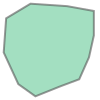

In [28]:
geo_df.iloc[0]['geometry']

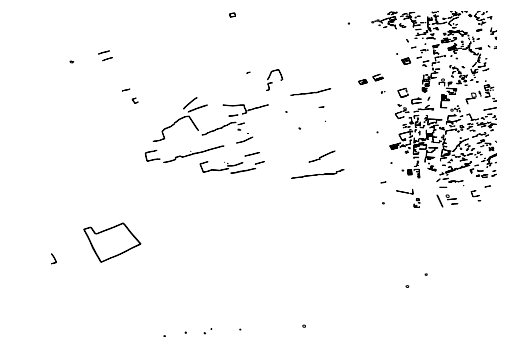

In [29]:
geoplot.polyplot(geo_df);

Lets view the tile data

In [30]:
grid_sizes[grid_sizes['Unnamed: 0']==TILE_NAME]

,Unnamed: 0,Xmax,Ymin
282,6110_4_0,0.009169,-0.00904


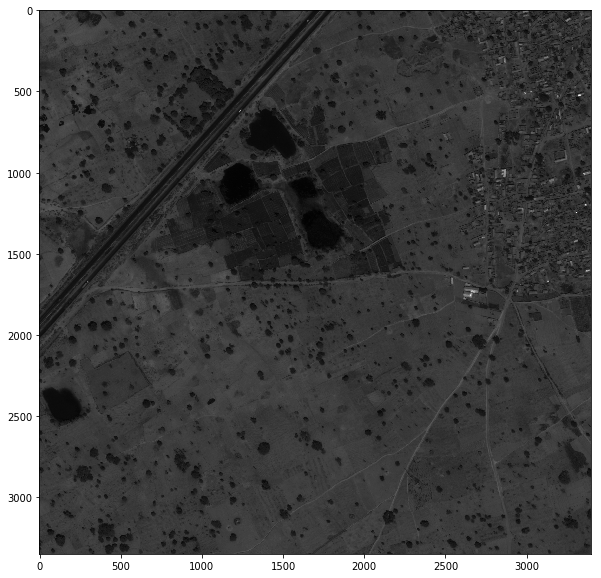

In [31]:
image_file = f'/Users/robincole/Documents/kaggle/dstl/three_band/{TILE_NAME}.tif'
im = io.imread(image_file)

im = io.imread(image_file)
f, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))
ax.imshow(rgb2gray(im), cmap=plt.cm.gray);

We can see there are many small man-made structures in this image

### Sample submission

`sample_submission.csv` - a sample submission file in the correct format
* ImageId - ID of the image
* ClassType - type of objects (1-10)
* MultipolygonWKT - the labeled area, which is multipolygon geometry represented in WKT format

In [32]:
sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')

In [33]:
sample_submission.head()

,ImageId,ClassType,MultipolygonWKT
0,6120_2_4,1,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
1,6120_2_4,2,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
2,6120_2_4,3,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
3,6120_2_4,4,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4,6120_2_4,5,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
